In [5]:
!pipreqs . --force


INFO: Not scanning for jupyter notebooks.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
INFO: Successfully saved requirements file in ./requirements.txt


In [4]:
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split

# Paths
dataset_path = '/home/mohsin/Documents/cv/cars_dataset'
output_base = '/home/mohsin/Documents/cv/split_dataset'  # Directory to store split dataset

# Create the output directory structure
output_train = os.path.join(output_base, 'train')
output_val = os.path.join(output_base, 'val')
output_test = os.path.join(output_base, 'test')

for folder in [output_train, output_val, output_test]:
    if not os.path.exists(folder):
        os.makedirs(folder)

# Create class-specific subdirectories
for class_name in ['front', 'back']:
    for subset in ['train', 'val', 'test']:
        class_folder = os.path.join(output_base, subset, class_name)
        if not os.path.exists(class_folder):
            os.makedirs(class_folder)

# Get all image paths and labels
image_paths = []
labels = []

for i, class_name in enumerate(['front', 'back']):
    class_folder = os.path.join(dataset_path, class_name)
    for filename in os.listdir(class_folder):
        image_paths.append(os.path.join(class_folder, filename))
        labels.append(i)  # 0 for 'front', 1 for 'back'

# Convert to numpy arrays
image_paths = np.array(image_paths)
labels = np.array(labels)

# Split into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Further split training into training and validation (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Function to move images to corresponding folders
def move_images(image_paths, labels, subset):
    for img_path, label in zip(image_paths, labels):
        class_name = 'front' if label == 0 else 'back'
        # Destination path
        dest_folder = os.path.join(output_base, subset, class_name)
        shutil.copy(img_path, dest_folder)

# Move images to train, val, and test folders
move_images(X_train, y_train, 'train')
move_images(X_val, y_val, 'val')
move_images(X_test, y_test, 'test')

print("Dataset has been split and moved to the corresponding folders.")


Dataset has been split and moved to the corresponding folders.


In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16  # You can use other models like ResNet, Inception, etc.
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Load pre-trained VGG16 model (without the top layer)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add global average pooling layer
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D()
])

# Freeze the layers of the base model
base_model.trainable = False

# ImageDataGenerators for train, validation, and test datasets
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images and apply transformations
train_generator = train_datagen.flow_from_directory(
    os.path.join(output_base, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',  # Assuming binary classification
    shuffle=False
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(output_base, 'val'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(output_base, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Function to extract features from all the images
def extract_features(generator):
    features = []
    labels = []
    for img_batch, label_batch in generator:
        feature_batch = model.predict(img_batch)
        features.append(feature_batch)
        labels.append(label_batch)
        # Stop if we've processed the entire dataset
        if len(features) * generator.batch_size >= generator.samples:
            break
    
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

# Extract features for the train, validation, and test sets
X_train_features, y_train = extract_features(train_generator)
X_val_features, y_val = extract_features(val_generator)
X_test_features, y_test = extract_features(test_generator)

2024-12-03 11:32:17.233347: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 11:32:17.242559: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-03 11:32:17.330403: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-03 11:32:17.399444: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733207537.479521    5425 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733207537.50

Found 629 images belonging to 2 classes.
Found 158 images belonging to 2 classes.
Found 197 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━

In [6]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Initialize the SVM model with a linear kernel
svm_model = SVC(kernel='linear')

# Train and evaluate using cross-validation on the training set
cross_val_scores = cross_val_score(svm_model, X_train_features, y_train, cv=5)

print(f"Cross-validation scores: {cross_val_scores}")
print(f"Mean cross-validation score: {cross_val_scores.mean():.4f}")

# Combine training and validation sets
X_train_full = np.concatenate([X_train_features, X_val_features], axis=0)
y_train_full = np.concatenate([y_train, y_val], axis=0)

# Train the SVM model on the entire training+validation set
svm_model.fit(X_train_full, y_train_full)

# Evaluate the trained SVM on the test set
y_pred = svm_model.predict(X_test_features)

Cross-validation scores: [0.98412698 0.91269841 0.98412698 0.95238095 0.984     ]
Mean cross-validation score: 0.9635


In [7]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Precision, Recall, F1-Score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display results
print("Confusion Matrix:")
print(cm)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Confusion Matrix:
[[96  2]
 [ 4 95]]
Accuracy: 0.9695
Precision: 0.9794
Recall: 0.9596
F1 Score: 0.9694


In [8]:
import warnings
warnings.filterwarnings("ignore")

Confusion Matrix:
[[96  2]
 [ 4 95]]
Accuracy: 0.9695
Precision: 0.9697
Recall: 0.9695
F1 Score: 0.9695


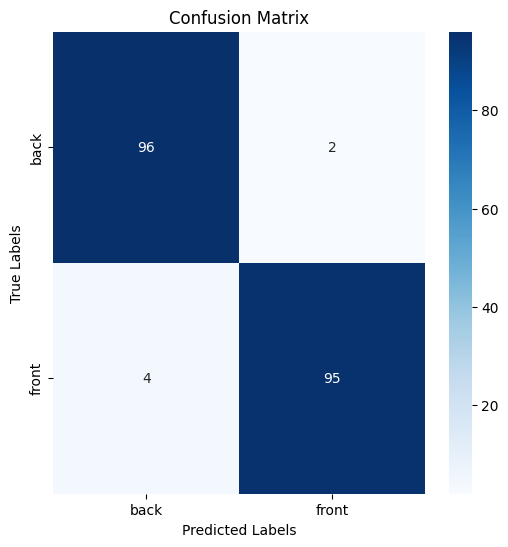

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Define class labels from the test generator's class_indices
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Precision, Recall, F1-Score
precision = precision_score(y_test, y_pred, average='weighted')  # 'weighted' averages across all classes
recall = recall_score(y_test, y_pred, average='weighted')  # 'weighted' averages across all classes
f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted' averages across all classes

# Display results
print("Confusion Matrix:")
print(cm)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot Confusion Matrix using seaborn heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig("cm.png")
plt.show()